In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
# Upload the data
# data will contain everything, names and locations
# df will contain the features used in the modeling
data = pd.read_csv('../data/processed/DecisionTreeData.csv', index_col=0)
data = data.loc[data.Year > 2009]
data.sort_index(inplace=True)
data.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,Year,NetPrice,Cost,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,Complete,RetentionFT,RetentionPT
47931,00100200,alabama a & m university,Normal,1,3,4,1.0,5.0,0.5129,4930.0,...,2010,8190.0,13762.0,xl,high,high,high,0.3306,0.7457,0.5000
47932,00105200,university of alabama at birmingham,Birmingham,1,3,4,1.0,5.0,0.8243,10661.0,...,2010,12838.0,18003.0,xl,high,highest,highest,0.4108,0.7997,0.7000
47933,02503400,amridge university,Montgomery,1,3,4,2.0,5.0,0.7143,370.0,...,2010,16546.0,20700.0,medium,highest,med,low,0.2308,0.8000,NaN
47934,00105500,university of alabama at huntsville,Huntsville,1,3,4,1.0,5.0,0.6614,5828.0,...,2010,7752.0,17064.0,xl,high,high,highest,0.4364,0.7545,0.5385
47935,00100500,alabama state university,Montgomery,1,3,4,1.0,5.0,0.4372,4882.0,...,2010,4061.0,14390.0,xl,high,high,high,0.2399,0.6352,0.4167


In [3]:
# Separate open and closed schoools
closed = data.loc[data.CURROPER == False]
closed.shape

(2759, 31)

In [4]:
# Resample the minority class
from sklearn.utils import resample
closed_upsample = resample(closed, replace=True, n_samples=(2759*2), random_state=123)

In [5]:
open_df = data.loc[data.CURROPER==True]
open_df.shape

(27923, 31)

In [6]:
current = open_df.loc[data.Year > 2012]
current.shape

(7440, 31)

In [7]:
data = pd.concat([current, closed_upsample], axis = 0)
data.shape

(12958, 31)

In [8]:
data.CURROPER.value_counts()

True     7440
False    5518
Name: CURROPER, dtype: int64

In [9]:
#df contains just the feature to train the model on
to_drop = ['OPEID', 'INSTNM', 'CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins',\
           'TuitionBins','ExpenditureBins','FacultyBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN', 'Year']
df = data.drop(to_drop, axis=1)
df.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,CURROPER,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT
70813,1,3,1.0,4051.0,True,9063.0,7459.0,0.8856,0.1049,0.256983,0.228252,0.150838,19500.0,18888.0,0.2914,0.6314
70814,1,3,1.0,11200.0,True,9033.0,17208.0,0.9106,0.2422,0.445502,0.184674,0.113279,16250.0,19990.0,0.5377,0.8016
70815,1,3,2.0,322.0,True,12057.0,5123.0,0.6721,0.8540,0.288591,0.382550,0.041270,10500.0,12300.0,0.6667,0.3750
70816,1,3,1.0,5525.0,True,8322.0,9352.0,0.6555,0.2640,0.377617,0.149758,0.116747,16500.0,20306.0,0.4835,0.8098
70817,1,3,1.0,5354.0,True,7813.0,7393.0,0.6641,0.1270,0.183563,0.256749,0.109778,15854.5,17400.0,0.2517,0.6219


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12958 entries, 70813 to 54596
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          12958 non-null  int64  
 1   PREDDEG            12958 non-null  int64  
 2   CONTROL            12958 non-null  float64
 3   UGDS               12958 non-null  float64
 4   CURROPER           12958 non-null  bool   
 5   TUITFTE            12958 non-null  float64
 6   INEXPFTE           12958 non-null  float64
 7   PFTFAC             12958 non-null  float64
 8   UG25abv            12958 non-null  float64
 9   COMP_ORIG_YR4_RT   12958 non-null  float64
 10  WDRAW_ORIG_YR4_RT  12958 non-null  float64
 11  ENRL_ORIG_YR4_RT   12958 non-null  float64
 12  DEBT_MDN           12958 non-null  float64
 13  Cost               12958 non-null  float64
 14  Complete           12958 non-null  float64
 15  RetentionFT        12958 non-null  float64
dtypes: bool(1), float6

In [11]:
y = df.CURROPER
X = df.drop('CURROPER', axis=1)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In [13]:
X_test.shape

(3888, 15)

# Decision Tree Model
Basis for comparison

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

## Explore just the criterion and max_depth features

Code modified from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

In [15]:
from sklearn import metrics
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, 31):
    gtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=21)
    gtree.fit(X_train, y_train)
    gpredict = gtree.predict(X_test)
    acc_gini.append(metrics.accuracy_score(y_test, gpredict))
    ##
    etree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=21)
    etree.fit(X_train, y_train)
    epredict = etree.predict(X_test)
    acc_entropy.append(metrics.accuracy_score(y_test, epredict))
    ##
    max_depth.append(i)

In [16]:
gini_max = max(acc_gini)
gini_idx = acc_gini.index(gini_max)
entropy_max = max(acc_entropy)
entropy_idx = acc_entropy.index(entropy_max)

if gini_max > entropy_max:
    depth = max_depth[gini_idx]
    crit = 'gini'
else:
    depth = max_depth[entropy_idx]
    crit='entropy'
    
print(depth)

28


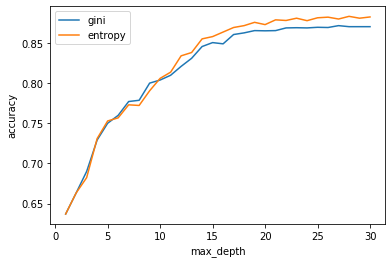

In [17]:
trees = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                     'acc_entropy':pd.Series(acc_entropy),
                     'max_depth':pd.Series(max_depth)})

plt.plot('max_depth', 'acc_gini', data=trees, label='gini')
plt.plot('max_depth', 'acc_entropy', data=trees, label='entropy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [18]:
# Train the decision tree using the identified hyperparameters
modelDT = DecisionTreeClassifier(criterion=crit, max_depth=depth, random_state=21)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=28, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

In [19]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict_proba(X_test)
#print(type(dt_pred_prob))

In [20]:
# Run this block for model evaluation 
#from sklearn import metrics
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = 0))

Model Metrics
Accuracy: 0.8829732510288066
Balanced accuracy: 0.888099968832788
Precision score for "Yes" 0.9370388588293163
Recall score for "No" 0.9227053140096618


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, dt_pred))

[[1528  128]
 [ 327 1905]]


In [22]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.82      0.92      0.87      1656
        True       0.94      0.85      0.89      2232

    accuracy                           0.88      3888
   macro avg       0.88      0.89      0.88      3888
weighted avg       0.89      0.88      0.88      3888



In [23]:
importances = modelDT.feature_importances_
#std = np.std([tree.feature_importances_ for tree in modelDT.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature UGDS (0.129668)
2. feature UG25abv (0.100067)
3. feature CONTROL (0.090980)
4. feature DEBT_MDN (0.080218)
5. feature TUITFTE (0.075373)
6. feature INEXPFTE (0.074190)
7. feature WDRAW_ORIG_YR4_RT (0.070553)
8. feature NUMBRANCH (0.068659)
9. feature Cost (0.068608)
10. feature COMP_ORIG_YR4_RT (0.063957)
11. feature RetentionFT (0.060380)
12. feature Complete (0.049739)
13. feature PFTFAC (0.035915)
14. feature PREDDEG (0.016717)
15. feature ENRL_ORIG_YR4_RT (0.014977)


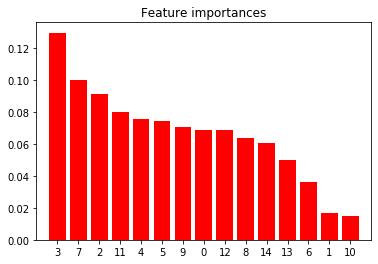

In [24]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center") #yerr=std[indices]
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

CONTROL and UGDS are the most prominent features - that predict open schools. (Control is categorical, so I'm not exactly sure how to interpret it). More enrollment increases prediction of being open.

## Decision Tree Model with various thresholds

In [25]:
threshold = []
accurate=[]
balance_acc = []
pred_proba = []

for thresh in range(50, 100, 5):
    new_pred = []
    for i in range(0, len(dt_pred_prob)):
        # print(len(dt_pred_prob))
        new_pred.append(dt_pred_prob[i, 1] > (thresh / 100.0))
    # print(new_pred)
    accurate.append(metrics.accuracy_score(y_test, new_pred))
    balance_acc.append(metrics.balanced_accuracy_score(y_test, new_pred))
    threshold.append(thresh)
    pred_proba.append(new_pred)

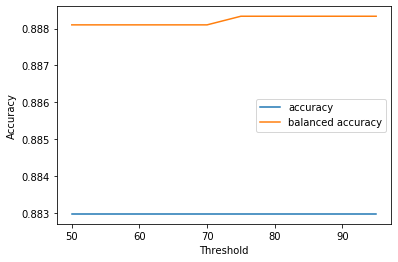

In [26]:
rate = pd.DataFrame({'threshold':pd.Series(threshold),
                     'accuracy':pd.Series(accurate),
                     'balance_acc':pd.Series(balance_acc)})

plt.plot('threshold', 'accuracy', data=rate, label='accuracy')
plt.plot('threshold', 'balance_acc', data=rate, label='balanced accuracy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
print("Balance Accuracy: ", max(balance_acc))
idx = balance_acc.index(max(balance_acc))
print("Threshold: ", threshold[idx])

Balance Accuracy:  0.8883337229234844
Threshold:  75


## AdaBoost model

In [28]:
ABmax_depth = []
score_a = []
score_b = []

for i in range(105, 131, 1):
    atree = AdaBoostClassifier(n_estimators=i, random_state=21)
    atree.fit(X_train, y_train)
    apredict = gtree.predict(X_test)
    score_a.append(metrics.accuracy_score(y_test, apredict))
    ##
    btree = AdaBoostClassifier(modelDT, n_estimators=i, random_state=21)
    btree.fit(X_train, y_train)
    bpredict = btree.predict(X_test)
    score_b.append(metrics.accuracy_score(y_test, bpredict))
    ##
    ABmax_depth.append(i)

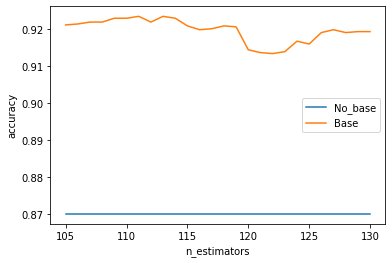

In [29]:
adatrees = pd.DataFrame({'score_a':pd.Series(score_a),
                     'score_b':pd.Series(score_b),
                     'n_estimators':pd.Series(ABmax_depth)})

plt.plot('n_estimators', 'score_a', data=adatrees, label='No_base')
plt.plot('n_estimators', 'score_b', data=adatrees, label='Base')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [30]:
ideal_estimators = max(score_b)
idx = score_b.index(ideal_estimators)
print(ABmax_depth[idx])

111


In [31]:
modelAB = AdaBoostClassifier(modelDT, n_estimators=ABmax_depth[idx], random_state=21)
modelAB.fit(X_train, y_train)
AB_pred = modelAB.predict(X_test)
print(metrics.accuracy_score(y_test, AB_pred))

0.9233539094650206


In [32]:
print(confusion_matrix(y_test, AB_pred))

[[1525  131]
 [ 167 2065]]


In [33]:
print(classification_report(y_test, AB_pred))

              precision    recall  f1-score   support

       False       0.90      0.92      0.91      1656
        True       0.94      0.93      0.93      2232

    accuracy                           0.92      3888
   macro avg       0.92      0.92      0.92      3888
weighted avg       0.92      0.92      0.92      3888



In [34]:
importances = modelAB.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelAB.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature Complete (nan)
2. feature DEBT_MDN (nan)
3. feature WDRAW_ORIG_YR4_RT (nan)
4. feature COMP_ORIG_YR4_RT (nan)
5. feature UG25abv (nan)
6. feature PFTFAC (nan)
7. feature INEXPFTE (nan)
8. feature TUITFTE (nan)
9. feature UGDS (nan)
10. feature CONTROL (nan)
11. feature PREDDEG (nan)
12. feature NUMBRANCH (nan)
13. feature ENRL_ORIG_YR4_RT (911040.690633)
14. feature Cost (-0.127943)
15. feature RetentionFT (-539876.028927)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:578: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


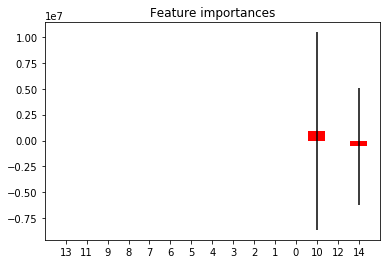

In [35]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Explore different threshold values for AB Model

In [36]:
AB_pred_prob = modelAB.predict_proba(X_test)

ABthreshold = []
ABaccurate=[]
ABbalance_acc = []
ABpred_proba = []

for thresh in range(50, 100, 5):
    new_pred = []
    for i in range(0, len(AB_pred_prob)):
        # print(len(dt_pred_prob))
        new_pred.append(AB_pred_prob[i, 1] > (thresh / 100.0))
    # print(new_pred)
    ABaccurate.append(metrics.accuracy_score(y_test, new_pred))
    ABbalance_acc.append(metrics.balanced_accuracy_score(y_test, new_pred))
    ABthreshold.append(thresh)
    ABpred_proba.append(new_pred)

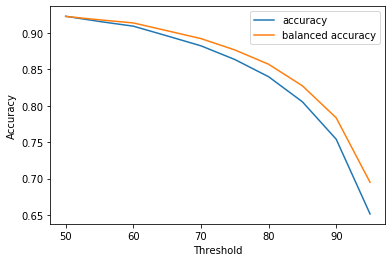

In [37]:
ABrate = pd.DataFrame({'threshold':pd.Series(ABthreshold),
                     'accuracy':pd.Series(ABaccurate),
                     'balance_acc':pd.Series(ABbalance_acc)})

plt.plot('threshold', 'accuracy', data=ABrate, label='accuracy')
plt.plot('threshold', 'balance_acc', data=ABrate, label='balanced accuracy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Exploration of misclassified schools

We are interested in predicting schools that might be in danger of closing. This would be schools that are currently open, but that the model predicts are closed. (These would be the "false negative" cases.) There are 224 schools in this class that could be explored further.

In [39]:
result_dict = {'CURROPER':y_test, 'Predicted':AB_pred}
results = pd.DataFrame(result_dict)
results.head()

,CURROPER,Predicted
77449,True,False
73209,True,True
74103,True,True
52260,False,False
73315,True,True


In [40]:
predicted = pd.concat([X_test, results], axis=1)
predicted.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT,CURROPER,Predicted
77449,4,1,3.0,172.0,11067.0,6322.0,0.4000,0.7151,0.558824,0.214286,0.000000,12417.0,26213.0,0.3636,0.6364,True,False
73209,1,1,3.0,270.0,5128.0,6008.0,0.3846,0.5444,0.446097,0.289963,0.000000,4857.0,15973.0,0.5523,0.6552,True,True
74103,1,2,3.0,557.0,9465.0,3661.0,0.3235,0.5673,0.414948,0.314433,0.018041,9500.0,22907.0,0.2300,0.6129,True,True
52260,1,1,3.0,129.0,7651.0,8874.0,0.7222,0.5130,0.576687,0.239264,0.000000,10885.0,38377.0,0.6124,0.6429,False,False
73315,1,2,1.0,3381.0,2635.0,5570.0,0.2457,0.2190,0.296157,0.247174,0.020231,5906.0,13481.0,0.3339,0.6095,True,True


In [41]:
false_pos = predicted.loc[(predicted.Predicted == True) & (predicted.CURROPER == False)]
false_pos.shape

(131, 17)

In [42]:
false_neg = predicted.loc[(predicted.Predicted==False) & (predicted.CURROPER==True)]
false_neg.shape

(167, 17)

## Generate graphs for the report

In [43]:
predicted['Result'] = np.nan
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==True), 'Result'] = 'TP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==False), 'Result'] = 'TN'
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==False), 'Result'] = 'FP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==True), 'Result'] = 'FN'
print(predicted.Result)

77449    FN
73209    TP
74103    TP
52260    TN
73315    TP
         ..
74774    TP
70580    TN
75179    FN
62279    TN
77223    TP
Name: Result, Length: 3888, dtype: object


In [44]:
to_graph = pd.merge(predicted, data)
to_graph.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,ADM_RATE,AVGFACSAL,PCTFLOAN,Year,NetPrice,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,RetentionPT
0,4,1,3.0,172.0,11067.0,6322.0,0.4000,0.7151,0.558824,0.214286,...,NaN,3611.0,0.8580,2013,21431.0,medium,highest,high,low,NaN
1,1,1,3.0,270.0,5128.0,6008.0,0.3846,0.5444,0.446097,0.289963,...,NaN,NaN,0.8523,2013,12903.0,medium,med,high,NaN,NaN
2,1,2,3.0,557.0,9465.0,3661.0,0.3235,0.5673,0.414948,0.314433,...,NaN,4376.0,0.6365,2013,18273.0,large,high,med,med,NaN
3,1,1,3.0,129.0,7651.0,8874.0,0.7222,0.5130,0.576687,0.239264,...,NaN,NaN,0.9190,2010,12618.0,small,high,high,NaN,0.6667
4,1,2,1.0,3381.0,2635.0,5570.0,0.2457,0.2190,0.296157,0.247174,...,NaN,6598.0,0.2513,2013,7722.0,xl,med,med,high,0.3977


In [45]:
to_graph.CONTROL = to_graph.CONTROL.astype('str')
to_graph.CONTROL.loc[to_graph.CONTROL == '1.0'] = 'Public'
to_graph.CONTROL.loc[to_graph.CONTROL == '2.0'] = 'NonProfit'
to_graph.CONTROL.loc[to_graph.CONTROL == '3.0'] = 'ForProfit'

to_graph.PREDDEG = to_graph.PREDDEG.astype('str')
#to_graph.drop(['EnrollmentBins', 'TuitionBins', 'ExpenditureBins', 'FacultyBins'], axis=1, inplace=True)
to_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7599 entries, 0 to 7598
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          7599 non-null   int64  
 1   PREDDEG            7599 non-null   object 
 2   CONTROL            7599 non-null   object 
 3   UGDS               7599 non-null   float64
 4   TUITFTE            7599 non-null   float64
 5   INEXPFTE           7599 non-null   float64
 6   PFTFAC             7599 non-null   float64
 7   UG25abv            7599 non-null   float64
 8   COMP_ORIG_YR4_RT   7599 non-null   float64
 9   WDRAW_ORIG_YR4_RT  7599 non-null   float64
 10  ENRL_ORIG_YR4_RT   7599 non-null   float64
 11  DEBT_MDN           7599 non-null   float64
 12  Cost               7599 non-null   float64
 13  Complete           7599 non-null   float64
 14  RetentionFT        7599 non-null   float64
 15  CURROPER           7599 non-null   bool   
 16  Predicted          7599 

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
predControl = to_graph.pivot_table(index='PREDDEG', columns=['CONTROL','Result'], aggfunc='size')
print(predControl)

CONTROL ForProfit                       NonProfit                     Public  \
Result         FN     FP      TN     TP        FN    FP     TN     TP     FN   
PREDDEG                                                                        
0            10.0    8.0   451.0  306.0       6.0   NaN   68.0   59.0    2.0   
1           114.0  128.0  2574.0  600.0       9.0  14.0  296.0   41.0    2.0   
2            11.0   18.0   422.0  164.0       3.0   3.0   50.0   49.0    NaN   
3             2.0    1.0   328.0   76.0       5.0  12.0  125.0  370.0    1.0   
4             1.0    NaN    90.0    8.0       3.0   NaN   88.0   76.0    NaN   

CONTROL                     
Result    FP     TN     TP  
PREDDEG                     
0        2.0   73.0   29.0  
1        7.0  250.0  176.0  
2        2.0   73.0  215.0  
3        5.0    3.0  166.0  
4        NaN    NaN    4.0  


In [47]:
false_neg = to_graph.loc[to_graph.Result == 'FN']
false_neg.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,ADM_RATE,AVGFACSAL,PCTFLOAN,Year,NetPrice,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,RetentionPT
0,4,1,ForProfit,172.0,11067.0,6322.0,0.4000,0.7151,0.558824,0.214286,...,NaN,3611.0,0.8580,2013,21431.0,medium,highest,high,low,NaN
109,1,1,ForProfit,23.0,12470.0,3685.0,0.1250,0.6087,0.220690,0.137931,...,NaN,NaN,0.1981,2013,9349.0,small,highest,med,NaN,NaN
124,2,2,ForProfit,1885.0,17502.0,2582.0,0.1313,0.5095,0.394105,0.319869,...,NaN,5611.0,0.8827,2013,14620.0,large,highest,med,med,0.1667
238,2,1,ForProfit,64.0,5445.0,9925.0,0.6000,0.4063,0.307393,0.291829,...,NaN,NaN,0.5625,2013,14931.0,small,med,high,NaN,0.7778
312,1,1,ForProfit,70.0,5214.0,2389.0,0.6667,0.8000,0.000000,0.000000,...,NaN,NaN,0.0000,2013,12955.0,small,med,low,NaN,0.8462


## UGDS - Undergraduate enrollment

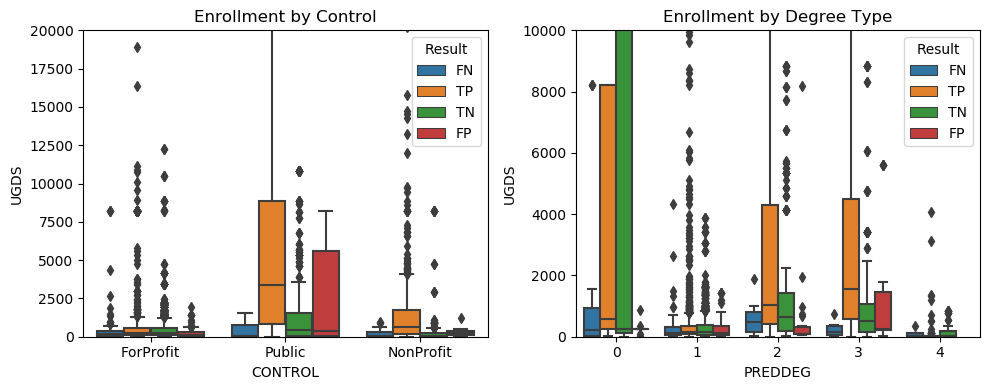

In [48]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 20000)
plt.title('Enrollment by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 10000)
plt.title('Enrollment by Degree Type')
plt.tight_layout()

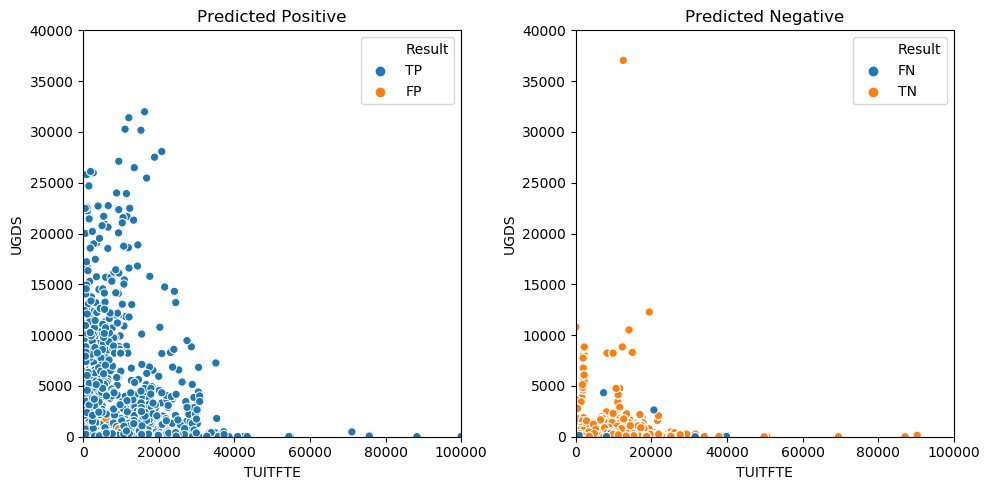

In [49]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue = 'Result')
plt.title('Predicted Positive')
plt.xlim(0,100000)
plt.ylim(0,40000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result')
plt.title('Predicted Negative')
plt.xlim(0,100000)
plt.ylim(0,40000)
plt.tight_layout()
plt.show()

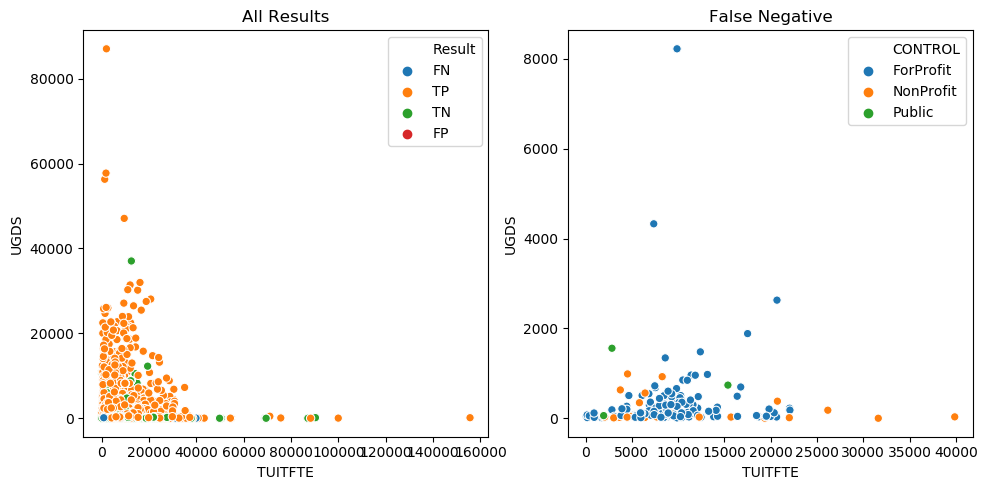

In [50]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph, hue = 'Result')
plt.title('All Results')
#plt.xlim(0,100000)
#plt.ylim(0,40000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.title('False Negative')
#plt.xlim(0,100000)
#plt.ylim(0,40000)
#plt.xlim(0,40000)
#plt.ylim(0,10000)
plt.tight_layout()
plt.show()

## Tuition and Cost

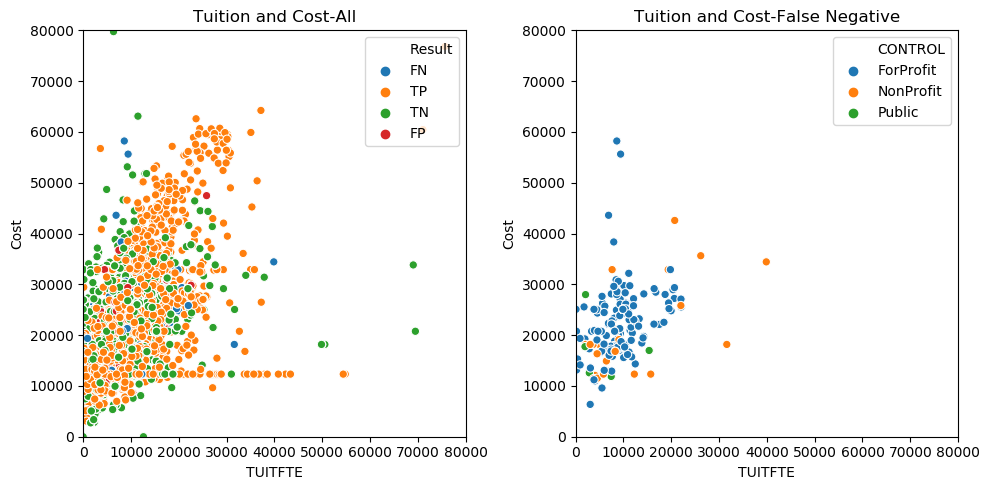

In [51]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph, hue = 'Result')
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Tuition and Cost-All')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Tuition and Cost-False Negative')
plt.tight_layout()
plt.show()

## Cost and Debt

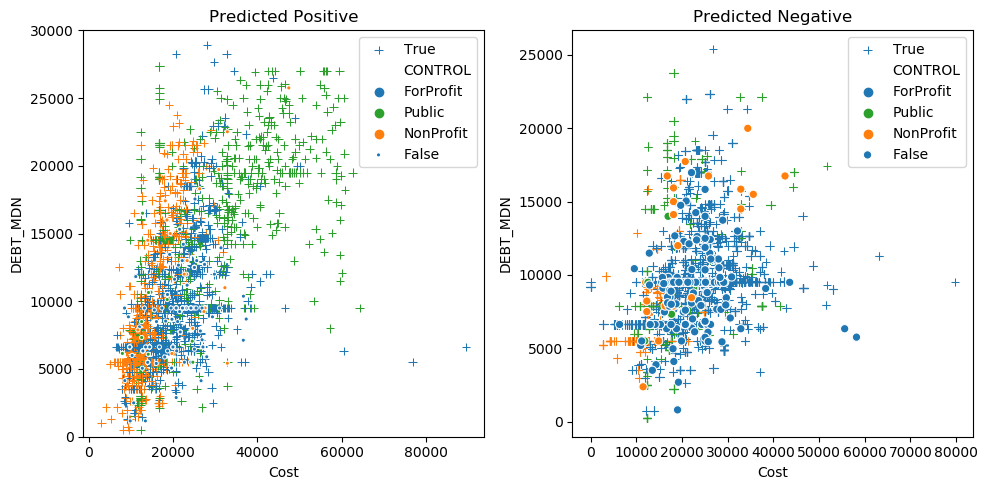

In [52]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='CONTROL')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='.', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Predicted Positive')
plt.ylim(0,30000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='o', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Predicted Negative')
plt.tight_layout()
plt.show()

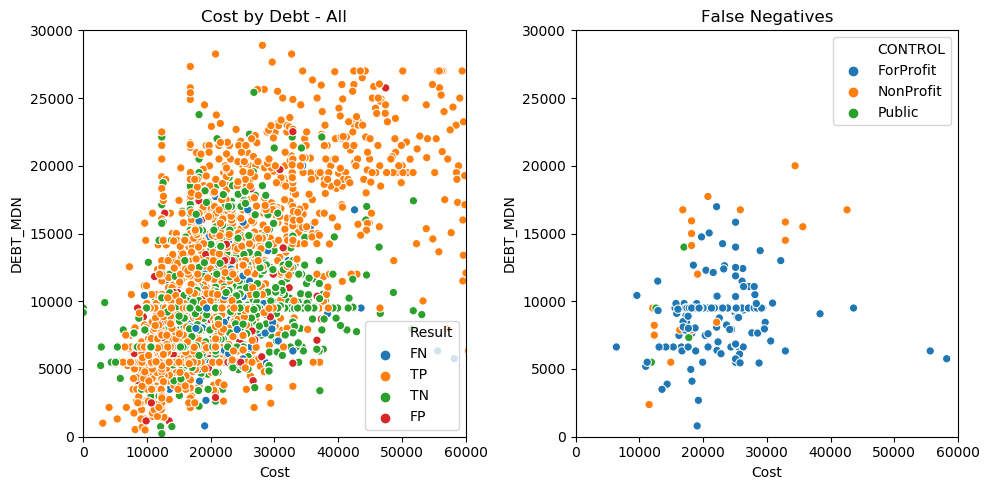

In [53]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph, hue='Result')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='.', label='False')
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.title('Cost by Debt - All')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='o', label='False')
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.title('False Negatives')
plt.ylim(0,30000)
plt.xlim(0,60000)
plt.tight_layout()
plt.show()

## NumBranch

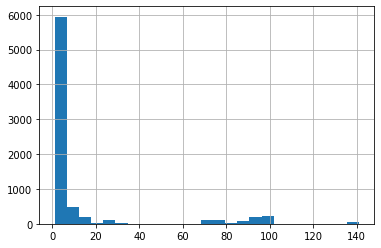

In [54]:
to_graph.NUMBRANCH.hist(bins=25)

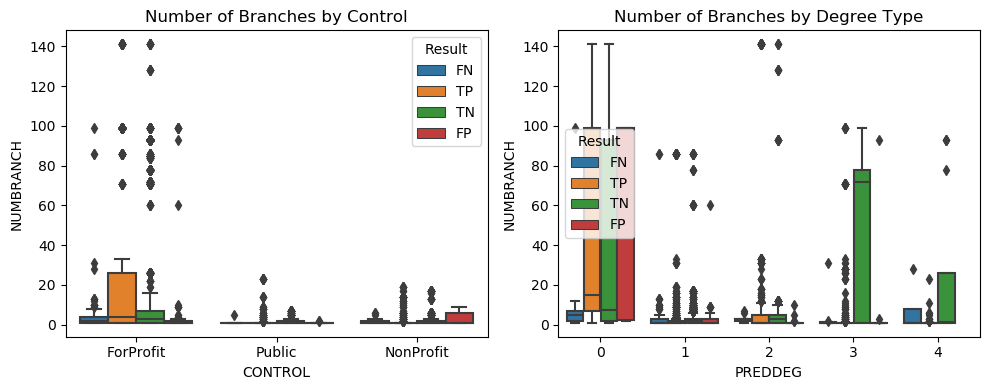

In [55]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
plt.title('Number of Branches by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
plt.title('Number of Branches by Degree Type')
plt.tight_layout()
plt.show()

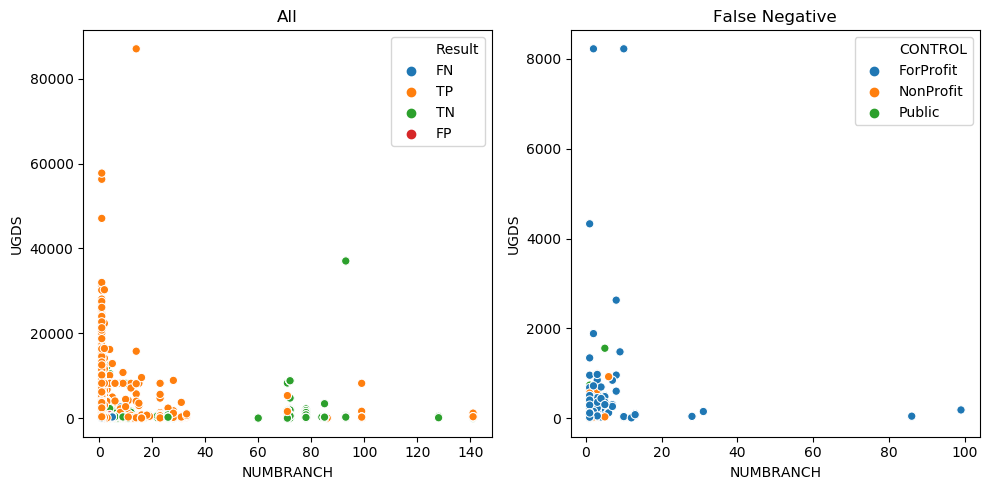

In [56]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph, hue = 'Result')
plt.title('All')

plt.subplot(1, 2, 2)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.title('False Negative')
plt.tight_layout()
plt.show()

## Instructional Expenditure

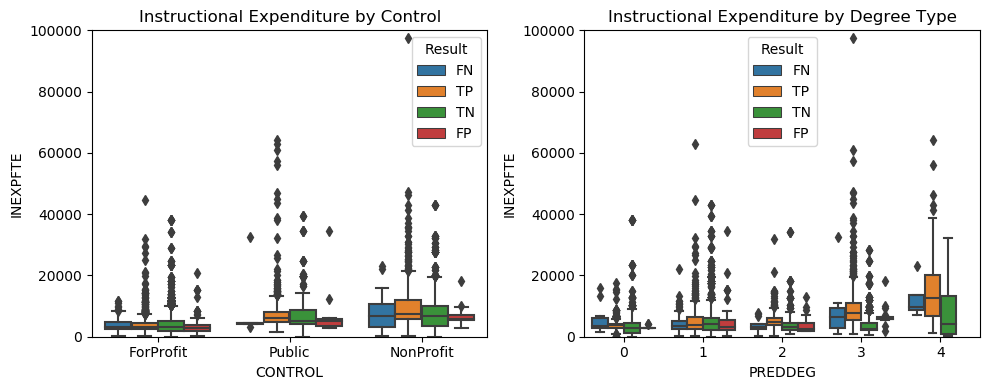

In [57]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Degree Type')
plt.tight_layout()
plt.show()

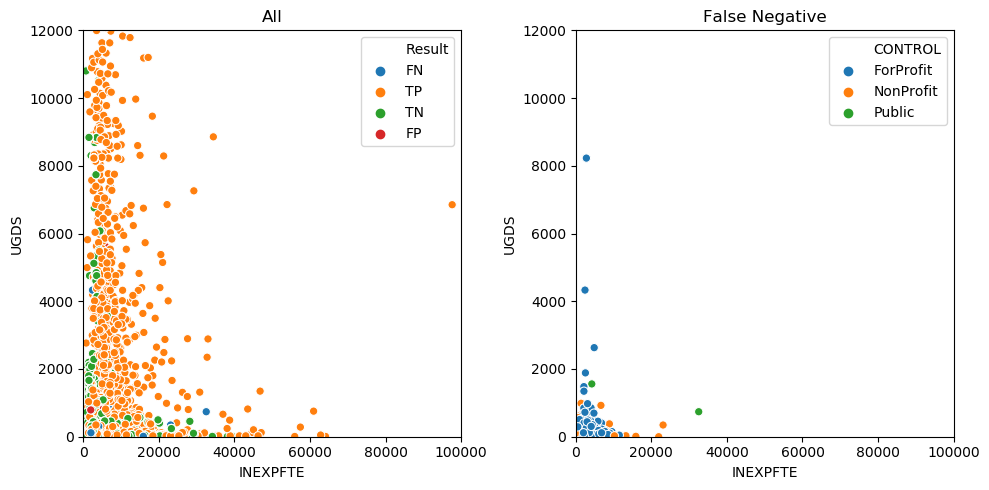

In [58]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph, hue = 'Result')
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('All')

plt.subplot(1, 2, 2)
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('False Negative')
plt.tight_layout()
plt.show()

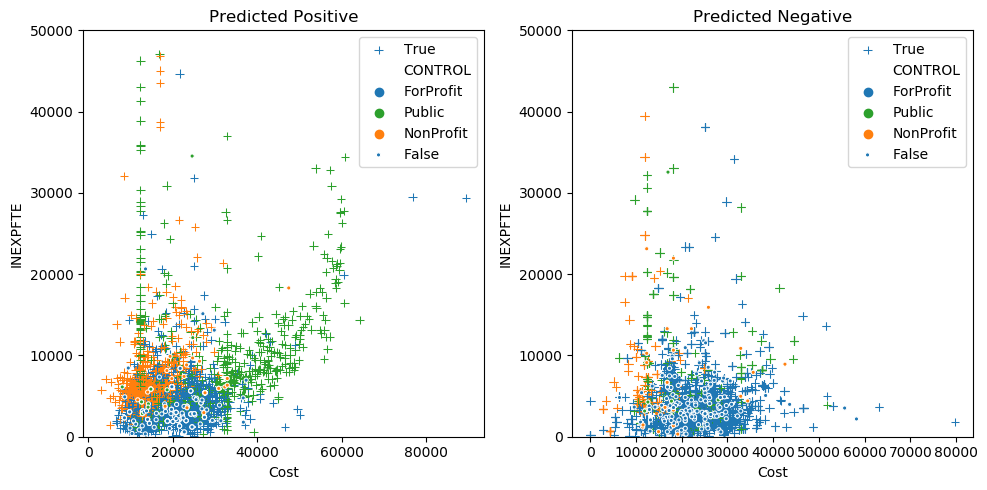

In [59]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue = 'Result')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='.', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylim(0, 50000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
#sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='.', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylim(0, 50000)
plt.title('Predicted Negative')
plt.tight_layout()
plt.show()